## 0. Import Libraries

In [2]:
from shapely.geometry import mapping
from cartopy.feature import ShapelyFeature
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import BoundaryNorm, ListedColormap

import xarray as xr
import numpy as np
import geopandas as gpd
import pandas as pd
import cartopy.io.shapereader as shpreader 
import matplotlib.pyplot as plt

import cartopy
import utils
import proplot
import matplotlib

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. General Options

In [6]:
# bias algorithm
bias_algo = 'QDM_era5land'
season = 'DJF' # DJF or JJA

# general data path
path_general = fr'/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data'

# variable name
name_variable_cosmo = 'TOT_PREC'
path_save = fr'{path_general}/data/{name_variable_cosmo}/'

### 1.1 Functions

In [83]:
def return_unique_options(season, time_resample):
    
    # path for resampling information
    if time_resample != 1:
        path_resample = fr'{time_resample}hrsum'
    else:
        path_resample = fr'{time_resample}hr'
        
    return season, time_resample, path_resample

def get_clev_norm(cmap, lower, upper, interval):
    
    clevs = np.arange(lower,
                      upper,
                      interval
                      )

    norm = BoundaryNorm(clevs,
                        ncolors=cmap.N, 
                        clip=True
                        )
    
    return clevs, norm

def xr_to_pd(dt, col_name='idx'):
        
    # to pd
    df_with_na = dt.to_dataframe().reset_index().drop(columns=['spatial_ref'])
    df_with_na['lat_lon'] = df_with_na['lat'].astype(str) + ' | ' + df_with_na['lon'].astype(str)
    df = df_with_na.dropna().reset_index(drop=True)  
    df = df[['TOT_PREC']].rename(columns={'TOT_PREC':col_name})
    
    return df

def merge_pd_data(ref, proj0, proj):
    
    return pd.concat([ref, proj0, proj],
                      axis=1)

def interp_data(data):
    return data.interpolate_na(dim='rlat', method="linear").interpolate_na(dim='rlon', method="linear")

In [7]:
fr'{path_general}/kmeans/era5land_result_{season}.nc'

'/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/kmeans/era5land_result_DJF.nc'

In [20]:
turkey_bool = xr.open_dataset(fr"{path_save}/cosmo/BC/vectorized_turkey_mask_from_era5land.nc").rename({'Tw':'TOT_PREC'})

### 1.2 Regional Data

In [8]:
# open regional data
regional_bool = xr.open_dataset(fr'{path_general}/kmeans/era5land_result_all.nc')

In [9]:
regional_bool['pred']

<xarray.Dataset>
Dimensions:  (rlat: 59, rlon: 137)
Coordinates:
  * rlat     (rlat) float64 -4.11 -4.0 -3.89 -3.78 -3.67 ... 1.94 2.05 2.16 2.27
  * rlon     (rlon) float64 -5.55 -5.44 -5.33 -5.22 -5.11 ... 9.08 9.19 9.3 9.41
Data variables:
    lat      (rlat, rlon) float64 ...
    lon      (rlat, rlon) float64 ...
    pred     (rlat, rlon) float64 ...

In [18]:
np.unique(regional_bool['pred'].values[~np.isnan(regional_bool['pred'].values)])

array([0., 1., 2., 3., 4., 5., 6.])

## 2. Open Index Data

### 2.1 Intensity Indices

#### 2.1.1 Reference

In [101]:
# uique options
season, time_resample, path_resample = return_unique_options(season, 1)
indice_name = fr'rx{time_resample}hr'
time_frame = '198501_200512' # 208101_210012 for proj or 198501_200512 for reference

# open data
path = fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{indice_name}_{time_frame}.nc"
intensity_idx_ref = xr.open_dataset(path).where(turkey_bool==1)[name_variable_cosmo][1:]

#### 2.1.2 Projection_0

In [102]:
# uique options
season, time_resample, path_resample = return_unique_options(season, 1)
indice_name = fr'rx{time_resample}hr'
time_frame = '206101_208012' # 208101_210012 for proj or 198501_200512 for reference

# open data
path = fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{indice_name}_{time_frame}.nc"
intensity_idx_proj_0 = xr.open_dataset(path).where(turkey_bool==1)[name_variable_cosmo]

#### 2.1.3 Projection

In [103]:
# uique options
season, time_resample, path_resample = return_unique_options(season, 1)
indice_name = fr'rx{time_resample}hr'
time_frame = '208101_210012' # 208101_210012 for proj or 198501_200512 for reference

# open data
path = fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{indice_name}_{time_frame}.nc"
intensity_idx_proj = xr.open_dataset(path).where(turkey_bool==1)[name_variable_cosmo]

### 2.2 Frequency - Percentile Indices

#### 2.2.1 Reference

In [24]:
# uique options
season, time_resample, path_resample = return_unique_options(season, 1)
indice_name = fr'R{time_resample}hr0.95P'
time_frame = '198501_200512' # 208101_210012 for proj or 198501_200512 for reference

# open data
path = fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{indice_name}_{time_frame}.nc"
freq_perc_idx_ref = xr.open_dataset(path).where(turkey_bool==1)[name_variable_cosmo]

#### 2.2.2 Projection_0

In [108]:
# uique options
season, time_resample, path_resample = return_unique_options(season, 1)
indice_name = fr'R{time_resample}hr0.95P'
time_frame = '206101_208012' # 208101_210012 for proj or 198501_200512 for reference

# open data
path = fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{indice_name}_{time_frame}.nc"
freq_perc_idx_proj_0 = xr.open_dataset(path).where(turkey_bool==1)[name_variable_cosmo][1:]

#### 2.2.3 Projection

In [26]:
# uique options
season, time_resample, path_resample = return_unique_options(season, 1)
indice_name = fr'R{time_resample}hr0.95P'
time_frame = '208101_210012' # 208101_210012 for proj or 198501_200512 for reference

# open data
path = fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{indice_name}_{time_frame}.nc"
freq_perc_idx_proj = xr.open_dataset(path).where(turkey_bool==1)[name_variable_cosmo]

### 2.3 Frequency - Absolute Indices

#### 2.3.1 Reference

In [109]:
# uique options
season, time_resample, path_resample = return_unique_options(season, 1)
#heavy_rain = 4 * time_resample # 4mm times the resample period
wet_hours = 0.1 #mm
indice_name = fr'R{time_resample}hr{wet_hours}mm'
time_frame = '198501_200512' # 208101_210012 for proj or 198501_200512 for reference

# open data
path = fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{indice_name}_{time_frame}.nc"
freq_abs_idx_ref = xr.open_dataset(path).where(turkey_bool==1)[name_variable_cosmo][1:]

#### 2.3.2 Projection_0

In [28]:
# uique options
season, time_resample, path_resample = return_unique_options(season, 1)
#heavy_rain = 4 * time_resample # 4mm times the resample period
wet_hours = 0.1 #mm
indice_name = fr'R{time_resample}hr{wet_hours}mm'
time_frame = '206101_208012' # 208101_210012 for proj or 198501_200512 for reference

# open data
path = fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{indice_name}_{time_frame}.nc"
freq_abs_idx_proj_0 = xr.open_dataset(path).where(turkey_bool==1)[name_variable_cosmo]

#### 2.3.3 Projection

In [29]:
# uique options
season, time_resample, path_resample = return_unique_options(season, 1)
#heavy_rain = 4 * time_resample # 4mm times the resample period
wet_hours = 0.1 #mm
indice_name = fr'R{time_resample}hr{wet_hours}mm'
time_frame = '208101_210012' # 208101_210012 for proj or 198501_200512 for reference

# open data
path = fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{indice_name}_{time_frame}.nc"
freq_abs_idx_proj = xr.open_dataset(path).where(turkey_bool==1)[name_variable_cosmo]

### 2.4 Persistence - Percentile Indices

#### 2.4.1 Reference

In [110]:
# uique options
season, time_resample, path_resample = return_unique_options(season, 1)
indice_name = fr'M{time_resample}hrCW0.95P'
time_frame = '198501_200512' # 208101_210012 for proj or 198501_200512 for reference

# open data
path = fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{indice_name}_{time_frame}.nc"
pers_perc_idx_ref = xr.open_dataset(path).where(turkey_bool==1)[name_variable_cosmo][1:]

#### 2.4.2 Projection_0

In [31]:
# uique options
season, time_resample, path_resample = return_unique_options(season, 1)
indice_name = fr'M{time_resample}hrCW0.95P'
time_frame = '206101_208012' # 208101_210012 for proj or 198501_200512 for reference

# open data
path = fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{indice_name}_{time_frame}.nc"
pers_perc_idx_proj_0 = xr.open_dataset(path).where(turkey_bool==1)[name_variable_cosmo]

#### 2.4.3 Projection

In [32]:
# uique options
season, time_resample, path_resample = return_unique_options(season, 1)
indice_name = fr'M{time_resample}hrCW0.95P'
time_frame = '208101_210012' # 208101_210012 for proj or 198501_200512 for reference

# open data
path = fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{indice_name}_{time_frame}.nc"
pers_perc_idx_proj = xr.open_dataset(path).where(turkey_bool==1)[name_variable_cosmo]

### 2.5 Persistence - Absolute Indices

#### 2.5.1 Reference

In [111]:
# uique options
season, time_resample, path_resample = return_unique_options(season, 1)
#heavy_rain = 4 * time_resample # 4mm times the resample period
wet_hours = 0.1 #mm
indice_name = fr'M{time_resample}hrCW{wet_hours}mm'
time_frame = '198501_200512' # 208101_210012 for proj or 198501_200512 for reference

# open data
path = fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{indice_name}_{time_frame}.nc"
pers_abs_idx_ref = xr.open_dataset(path).where(turkey_bool==1)[name_variable_cosmo][1:]

#### 2.5.2 Projection_0

In [34]:
# uique options
season, time_resample, path_resample = return_unique_options(season, 1)
#heavy_rain = 4 * time_resample # 4mm times the resample period
wet_hours = 0.1 #mm
indice_name = fr'M{time_resample}hrCW{wet_hours}mm'
time_frame = '206101_208012' # 208101_210012 for proj or 198501_200512 for reference

# open data
path = fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{indice_name}_{time_frame}.nc"
pers_abs_idx_proj_0 = xr.open_dataset(path).where(turkey_bool==1)[name_variable_cosmo]

#### 2.5.3 Projection

In [35]:
# uique options
season, time_resample, path_resample = return_unique_options(season, 1)
#heavy_rain = 4 * time_resample # 4mm times the resample period
wet_hours = 0.1 #mm
indice_name = fr'M{time_resample}hrCW{wet_hours}mm'
time_frame = '208101_210012' # 208101_210012 for proj or 198501_200512 for reference

# open data
path = fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{indice_name}_{time_frame}.nc"
pers_abs_idx_proj = xr.open_dataset(path).where(turkey_bool==1)[name_variable_cosmo]

## 3. Visualize

### 3.1 Options

In [37]:
# Parameters to change (plot) -------------------

# projection
lcc = utils.get_proj_info_model()

# fig features
fig_array = [[1, 1, 1],
             [2, 2, 2],
             [3, 3, 3],
             [4, 4, 4],
             [5, 5, 5]
            ]

# graphic number
graphic_no = 5

# variable and dimension names
name_var = 'TOT_PREC'
name_lon = 'rlon'
name_lat = 'rlat'

col_names = [
    'Intensity',
    'Freq-Absolute',
    'Freq-Percentile',
    'Pers-Absolute',
    'Pers-Percentile',
]


idx_names = [fr'Rx{time_resample}hr', 
             fr'R{time_resample}hr0.95P',
             fr'R{time_resample}hr{wet_hours}mm',
             fr'M{time_resample}hrCW0.95P',
             fr'M{time_resample}hrCW{wet_hours}mm'
             ]

### 3.2 Mean Plot

/tmp/ipykernel_730/3196039741.py:22: ProplotWarning: Ignoring unused projection-specific format() keyword argument(s): {'lonlim': (25.8, 45.1), 'latlim': (35.0, 42.2), 'longrid': False, 'latgrid': False}
  axs.format(lonlim=(25.8, 45.1),


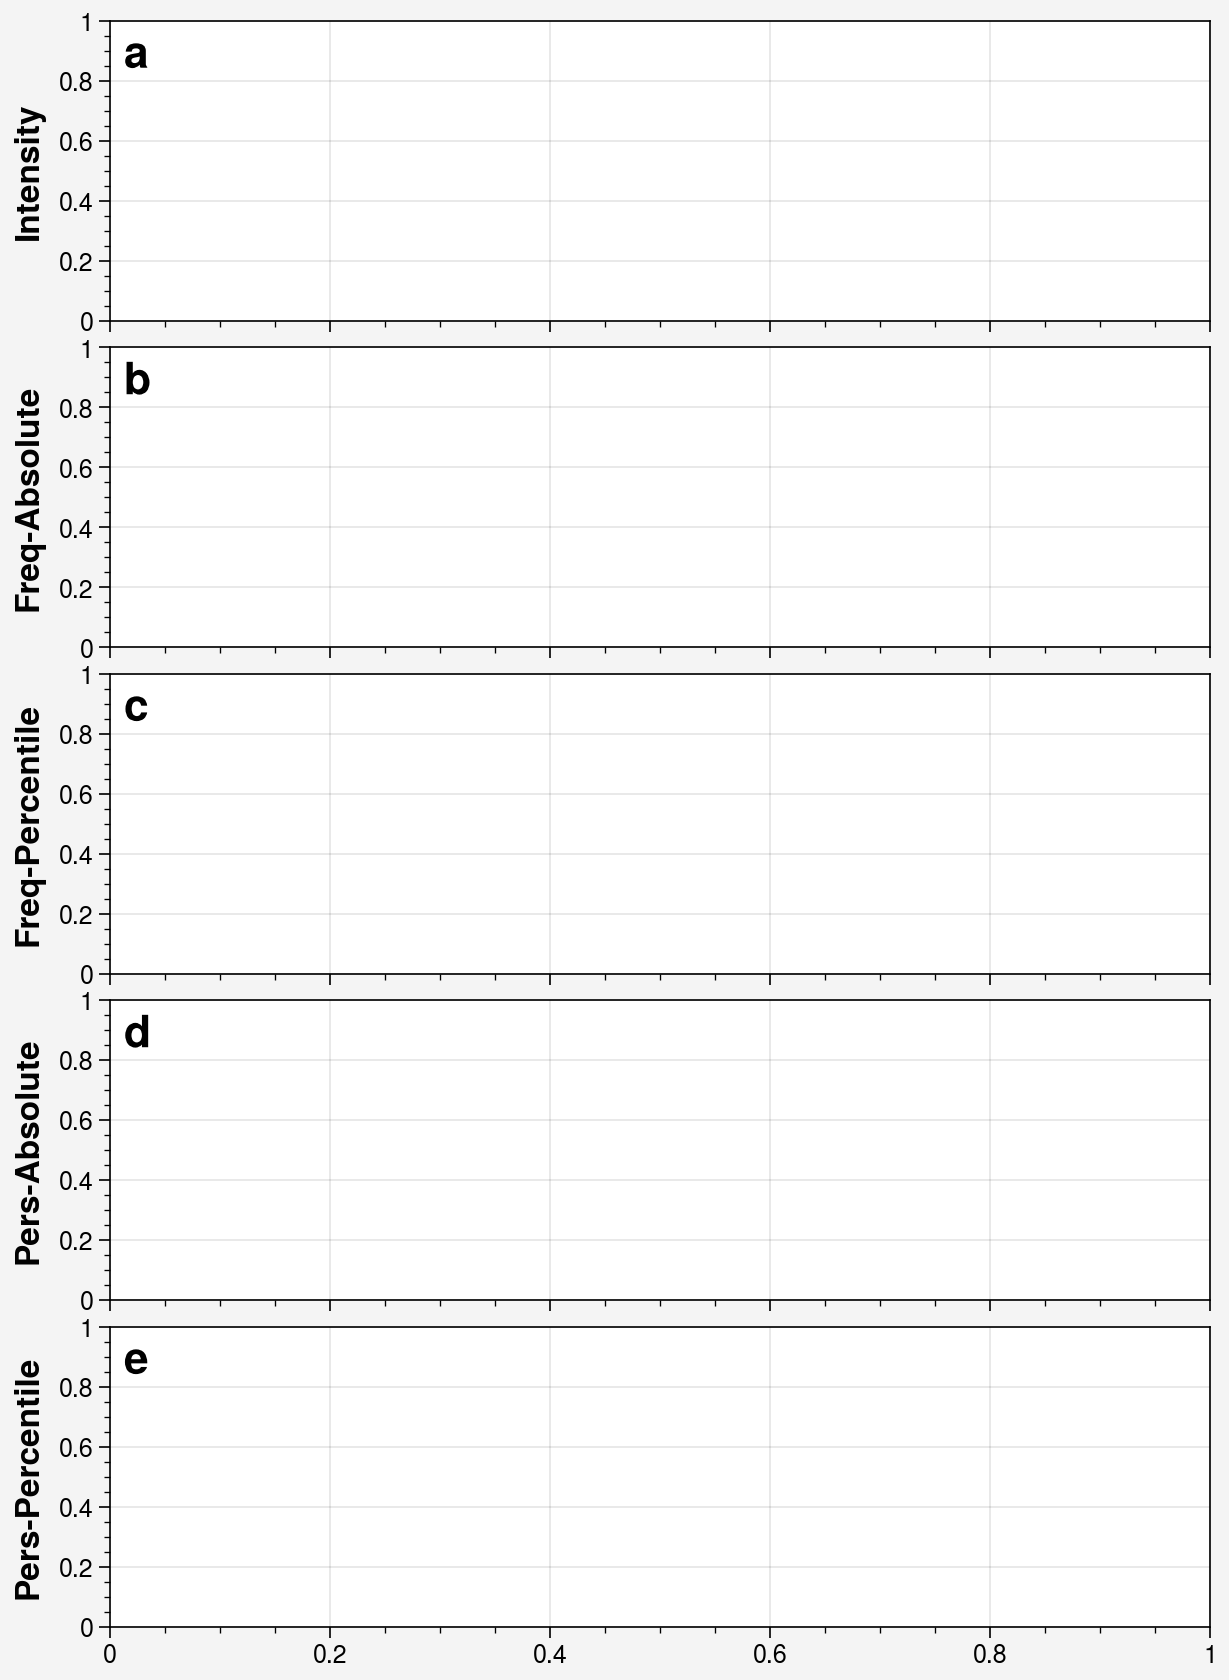

In [46]:
# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            axheight=1.5, 
                            axwidth=5.5,
                            proj=None,
                            hratios=tuple(np.ones(len(fig_array), dtype=int)),
                            includepanels=True,
                            hspace=1.06,
                            wspace=-0.16,
                            sharey=0
                           )

# format whole figure
axs.format(abcloc='ul',
           #abcbbox = True,
           abc_kw={'size':16},
           abc=True,
           zorder=50
          )

# Turkey limits
axs.format(lonlim=(25.8, 45.1), 
           latlim=(35., 42.2), 
           longrid=False, 
           latgrid = False
          )

# format headers
axs.format(rowlabels=col_names,
           leftlabelsize=12,
           toplabelsize=12,
            
          )

# intensity
axs[0].barplot()

In [47]:
import proplot as pplt
import numpy as np
import pandas as pd

# Sample data
N = 500
state = np.random.RandomState(51423)
data1 = state.normal(size=(N, 5)) + 2 * (state.rand(N, 5) - 0.5) * np.arange(5)
data1 = pd.DataFrame(data1, columns=pd.Index(list('abcde'), name='label'))


In [48]:
data1

label,a,b,c,d,e
0,-0.613555,0.682797,0.922802,2.712688,0.332775
1,0.914384,0.266436,-1.576431,2.764987,-0.224940
2,0.502818,0.014872,0.858294,-2.078291,1.971858
3,0.353395,1.489007,3.775098,1.625966,-3.805613
4,0.569091,-1.256706,0.251128,1.796257,-1.186086
...,...,...,...,...,...
495,0.728050,1.285810,-0.659133,1.014121,3.038811
496,0.044665,-1.075686,1.459919,2.106872,5.065045
497,0.059118,-0.620517,-1.272589,-1.066364,-2.592830
498,-1.656022,-0.385707,-2.473468,-1.206205,0.350170


In [112]:
intensity_mean_pd = xr_to_pd(intensity_idx_ref.mean(dim='year'), 
                        col_name='Ref')

In [113]:
intensity_mean_pd

,Ref
0,5.308914
1,5.134122
2,4.313207
3,3.223227
4,3.811248
...,...
5108,2.389591
5109,2.228923
5110,2.467330
5111,2.199506


In [90]:
intensity_pd

,Ref
0,4.846824
1,4.806123
2,3.930141
3,2.530481
4,2.016036
...,...
107368,2.060345
107369,1.794809
107370,1.253201
107371,1.459939


In [140]:
def xr_to_pd(dt, col_name):
        
    # to pd
    df_with_na = dt.to_dataframe().reset_index().drop(columns=['spatial_ref'])
    df_with_na['lat_lon'] = df_with_na['lat'].astype(str) + ' | ' + df_with_na['lon'].astype(str)
    df = df_with_na.dropna().reset_index(drop=True)  
    df = df[['TOT_PREC']].rename(columns={'TOT_PREC':'idx'})
    df['time_line'] = col_name
    
    return df

def merge_pd_data(ref, proj0, proj):
    
    return pd.concat([ref, proj0, proj],
                      axis=0).reset_index(drop=True)

In [141]:
intensity_mean_pd = merge_pd_data(xr_to_pd(intensity_idx_ref.mean(dim='year'), col_name='Ref'),
                              xr_to_pd(intensity_idx_proj_0.mean(dim='year'), col_name='Proj-1'),
                              xr_to_pd(intensity_idx_proj.mean(dim='year'), col_name='Proj-2'))

In [142]:
intensity_mean_pd

,idx,time_line
0,5.308914,Ref
1,5.134122,Ref
2,4.313207,Ref
3,3.223227,Ref
4,3.811248,Ref
...,...,...
15334,2.769510,Proj-2
15335,2.512225,Proj-2
15336,3.097484,Proj-2
15337,2.665849,Proj-2


In [134]:
kl = xr_to_pd(intensity_idx_ref.mean(dim='year'))

In [138]:
kl['time_line'] = 'Ref'

In [139]:
kl

,idx,time_line
0,5.308914,Ref
1,5.134122,Ref
2,4.313207,Ref
3,3.223227,Ref
4,3.811248,Ref
...,...,...
5108,2.389591,Ref
5109,2.228923,Ref
5110,2.467330,Ref
5111,2.199506,Ref


In [ ]:
intensity_mean_pd

In [118]:
import seaborn as sns
dnn = sns.load_dataset("penguins")

In [120]:
dnn

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


In [116]:
intensity_mean_pd

,Ref,Proj-1,Proj-2
0,5.308914,5.181679,4.392850
1,5.134122,5.423566,5.096537
2,4.313207,4.187412,4.141258
3,3.223227,3.269186,3.098315
4,3.811248,3.736957,3.595550
...,...,...,...
5108,2.389591,2.525764,2.769510
5109,2.228923,2.280676,2.512225
5110,2.467330,2.897511,3.097484
5111,2.199506,2.422761,2.665849


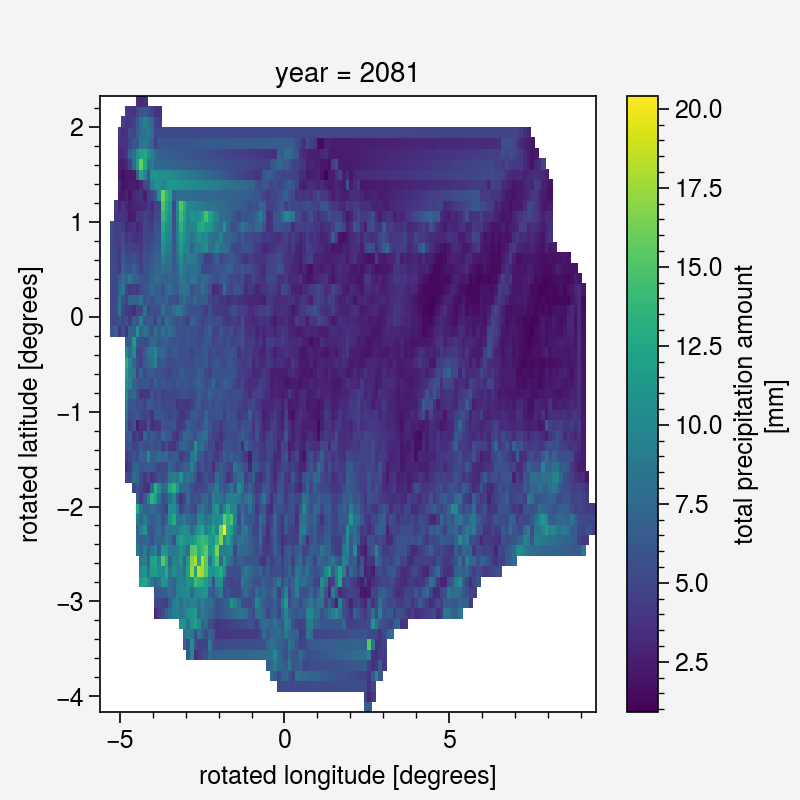

In [95]:
interp_data(xr.open_dataset(path))['TOT_PREC'][0].plot()